In [11]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from net import Net
from aco import ACO
from utils import gen_pyg_data, gen_instance

torch.manual_seed(1234)

lr = 3e-4
EPS = 1e-10
T = 5
device = 'cuda:0'

In [12]:
def train_instance(n, model, optimizer, n_ants):
    model.train()
    demands, distances = gen_instance(n, device)
    pyg_data = gen_pyg_data(demands, distances, device)
    heu_vec = model(pyg_data)
    heu_mat = heu_vec.reshape((n+1, n+1)) + EPS
    aco = ACO(
        distances=distances,
        demand=demands,
        n_ants=n_ants,
        heuristic=heu_mat,
        device=device
        )
    
    costs, log_probs = aco.sample()
    baseline = costs.mean()
    reinforce_loss = torch.sum((costs - baseline) * log_probs.sum(dim=0)) / aco.n_ants
    optimizer.zero_grad()
    reinforce_loss.backward()
    optimizer.step()

def infer_instance(n, model, n_ants):
    model.eval()
    demands, distances = gen_instance(n, device)
    pyg_data = gen_pyg_data(demands, distances, device)
    heu_vec = model(pyg_data)
    heu_mat = heu_vec.reshape((n+1, n+1)) + EPS
    aco = ACO(
        distances=distances,
        demand=demands,
        n_ants=n_ants,
        heuristic=heu_mat,
        device=device
        )
    costs, log_probs = aco.sample()
    aco.run(n_iterations=T)
    baseline = costs.mean()
    best_sample_cost = torch.min(costs)
    best_aco_cost = aco.lowest_cost
    return baseline.item(), best_sample_cost.item(), best_aco_cost.item()

In [13]:
def train_epoch(n_node,
                n_ants, 
                steps_per_epoch, 
                net, 
                optimizer
                ):
    for _ in range(steps_per_epoch):
        train_instance(n_node, net, optimizer, n_ants)


@torch.no_grad()
def validation(n_node, n_ants, epoch, net, animator=None):
    sum_bl, sum_sample_best, sum_aco_best = 0, 0, 0
    n_val = 100
    for _ in range(n_val):
        bl, sample_best, aco_best = infer_instance(n_node, net, n_ants)
        sum_bl += bl; sum_sample_best += sample_best; sum_aco_best += aco_best
    avg_bl, avg_sample_best, avg_aco_best = sum_bl/n_val, sum_sample_best/n_val, sum_aco_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best, avg_aco_best))
    return avg_bl, avg_sample_best, avg_aco_best

In [14]:
def train(n_node, n_ants, steps_per_epoch, epochs):
    net = Net().to(device)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj.", "Best ACO obj."])
    
    avg_bl, avg_best, avg_aco_best = validation(n_node, n_ants, -1, net, animator)
    val_results = [(avg_bl, avg_best, avg_aco_best)]
    
    val_best = 1e10
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        train_epoch(n_node, n_ants, steps_per_epoch, net, optimizer)
        sum_time += time.time() - start
        avg_bl, avg_best, avg_aco_best = validation(n_node, n_ants, epoch, net, animator)
        val_results.append((avg_bl, avg_best, avg_aco_best))
        if avg_aco_best < val_best:
            val_best = avg_aco_best
            torch.save(net.state_dict(), f'../pretrained/cvrp/cvrp{n_node}.pt')
        
    print('total training duration:', sum_time)
    
    for epoch in range(-1, epochs):
        print(f'epoch {epoch}:', val_results[epoch+1])
    

Learn heuristic for CVRP20: 

total training duration: 91.96692395210266
epoch -1: (11.26026412010193, 9.535970921516418, 9.170656371116639)
epoch 0: (7.623959250450135, 6.368954763412476, 5.725151834487915)
epoch 1: (5.936471962928772, 5.143857545852661, 4.894101543426514)
epoch 2: (5.857453465461731, 5.114370307922363, 4.91229638338089)
epoch 3: (5.536002280712128, 4.8599144864082335, 4.727360107898712)
epoch 4: (5.5081150388717655, 4.849801592826843, 4.702854442596435)


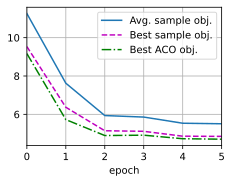

In [15]:
n_node, n_ants = 20, 20
steps_per_epoch = 128
epochs = 5
train(n_node, n_ants, steps_per_epoch, epochs)

Learn heuristic for CVRP100: 

total training duration: 221.1994173526764
epoch -1: (64.38051837921142, 60.250432891845705, 59.84107391357422)
epoch 0: (22.280575046539308, 19.701774158477782, 18.491709766387938)
epoch 1: (18.60718433380127, 16.76278269767761, 16.086385679244994)
epoch 2: (18.23793418884277, 16.63415777206421, 15.981523962020875)
epoch 3: (17.769026260375977, 16.029671440124513, 15.484584770202638)
epoch 4: (17.5504932308197, 15.965454854965209, 15.467407588958741)


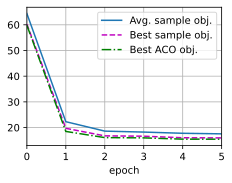

In [16]:
n_node, n_ants = 100, 50
steps_per_epoch = 128
epochs = 5
train(n_node, n_ants, steps_per_epoch, epochs)

Learn heuristic for CVRP500: 

total training duration: 1053.3798639774323
epoch -1: (273.7754501342773, 263.2929440307617, 260.8473345947266)
epoch 0: (115.62877433776856, 109.95573707580566, 108.50335960388183)
epoch 1: (69.69951522827148, 66.9304239654541, 65.51032752990723)
epoch 2: (73.55992790222167, 70.5244384765625, 69.09001358032226)
epoch 3: (68.85360900878906, 65.97909473419189, 64.72845714569092)
epoch 4: (68.78896701812744, 66.25900177001954, 65.23113815307617)


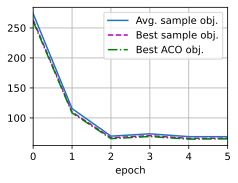

In [17]:
n_node, n_ants = 500, 50
steps_per_epoch = 128
epochs = 5
train(n_node, n_ants, steps_per_epoch, epochs)